In [ ]:
# https://dc.etsu.edu/cgi/viewcontent.cgi?article=4651&context=etd

'''
The model is
SU Supplier
C Customer
    BU 
        Bulk container Customers, 
        arrive according to a Poisson Process
        order with a Q1 = 100 units
    DR 
        Drum container Customers, 
        arrive according to a Poisson Process
        order with Q2 = 10 units
        
'''

In [ ]:
import simpy 
import numpy as np
import math, itertools
import sys, os

class P:
    # This is a class that contains all the parameters (P) for a Simulation
    #External orders arrive to DR according to a Poisson process with daily mean of (150/10)/30=1/2 orders/day
    externalToDRMean = 1/2
    # External orders placed to DR have a lot size of 10 units/order
    DRorderLotSize = 10
    # External orders arrive to BU according to a Poisson process with daily mean of (50/20)/30=5/60 orders/day
    externalToBUMean = 5/60
    # External orders placed to BU have a lot size of 20 units/order
    BUorderLotSize = 20
    # BU places replenishment orders in lot sizes of 100 to upstream supplier
    Q_1 = 100
    # DR places replenishment orders in lot sizes of 20 to BU
    Q_2 = 20
    # Re−order point for BU is 20+(200/30)∗7 units
    ROP_BU = 20+(200/30)*7
    # Re−order point for DR is 10+(150/30)∗2 units
    ROP_DR = 10+(150/30)*2
    # Replenishment leadtime from supplier to BU is 7 days
    LT_1 = 7
    # Replenishment leadtime from BU to DR is 2 days
    LT_2 = 2
    # Run the simulation for 12 months
    simulationTimeMax = 12*30
    
class S :
    # This is a class that defines a Simulation (S)
    Inv = None
    DRwaits = [ ] # Drum Containers
    BUwaits = [ ] # Bulk
    nBUCustomers = 0
    nDRCustomers = 0
    BU_Dem_day = list(itertools.repeat(0, P.simulationTimeMax))
    DR_Dem_day = list(itertools.repeat(0, P.simulationTimeMax))
    
class Inventory:
    def __init__(self, env):
        self.env = env
        self.BU_inv = simpy.Container(env, init = P.ROP_BU)
        self.DR_inv = simpy.Container(env, init = P.ROP_DR)
        self.mon_procBU = env.process(self.monitor_BU_inv(env))
        self.mon_procDR = env.process(self.monitor_DR_inv(env))
        self.BU_inv_dataset = []
        self.DR_inv_dataset = []

    def monitor_BU_inv(self, env):
        while True :
            self.BU_inv_dataset.append(self.BU_inv.level)
            if self.BU_inv.level <= P.ROP_BU:
                print('Time {:.2f}: BU inventory reached ROP: BU places replenishment order'.format(self.env.now))
                yield self.env.timeout(P.LT_1)
                print('Time {:.2f}: BU replenishment inventory arrives'.format(self.env.now))
                yield self.BU_inv.put(P.Q_1)
                print('Time {:.2f}: BU replenishment order is added to inventory'.format(self.env.now))
            yield self.env.timeout(1)
                
    def monitor_DR_inv(self, env):
        while True:
            self.DR_inv_dataset.append(self.DR_inv.level)
            if self.DR_inv.level <= P.ROP_DR:
                print('Time {:.2f}: DR inventory reached ROP: DR places replenishment order to BU'.format(self.env.now))
                yield self.BU_inv.get(P.Q_2)
                print('Time {:.2f}: BU fills DR replenishment request'.format(self.env.now))
                yield self.env.timeout(P.LT_2)
                print('Time {:.2f}: DR replenishment inventory arrives from BU'.format(self.env.now))
                yield self.DR_inv.put(P.Q_2)
                print('Time {:.2f}: DR replenishment order is added to inventory'.format(self.env.now))
            yield self.env.timeout(1)
            
class DRCustomer(object):
    def __init__(self, env , name = '' ):
        self.env = env
        self.action = self.env.process(self.ordertoDR())
        if(name == ''):
            self.name = 'RandomDRCustomer' + str(np.random.randint(100))
        else:
            self.name = name

    def DRorderToBU(self):
        print('Time {:.2f}: DR places order to BU to fill order for {}'.format(self.env.now, self.name))
        yield S.Inv.BU_inv.get(P.DRorderLotSize)
        yield self.env.timeout(P.LT_2)
        yield S.Inv.DR_inv.put(P.DRorderLotSize)

    def ordertoDR(self):
        startTime_DR = self.env.now
        j = math.floor(self.env.now)
        S.DR_Dem_day[j] += 1
        print('Time {:.2f}: {} places order to DR'.format(self.env.now, self.name))
        if S.Inv.DR_inv.level < P.DRorderLotSize:
            self.env.process(self.DRorderToBU())
        yield S.Inv.DR_inv.get(P.DRorderLotSize)
        print('Time {:.2f}: {} recieves order from DR'.format(self.env.now, self.name))
        waitTime_DR = self.env.now - startTime_DR
        print('{} had to wait {:.2f} days'.format(self.name, waitTime_DR))
        S.DRwaits.append(waitTime_DR)
        
class BUCustomer(object):
    def __init__(self, env, name = ''):
        self.env = env
        self.action = self.env.process(self.ordertoBU())
        if (name ==''):
            self.name = 'RandomBUCustomer' + str(np.random.randint(100))
        else:
            self.name = name
    
    def ordertoBU(self):
        startTime_BU = self.env.now
        i = math.floor(self.env.now)
        S.BU_Dem_day[i] += 1
        print('Time {:.2f}: {} places order to BU'.format(self.env.now, self.name))
        yield S.Inv.BU_inv.get(P.BUorderLotSize)
        print('Time {:.2f}: {} receives order'.format(self.env.now, self.name))
        waitTime_BU = self.env.now - startTime_BU
        print('{} had to wait {:.2f} days'.format(self.name, waitTime_BU))
        S.BUwaits.append(waitTime_BU)
        
class DROrderProcessor(object):
    def __init__(self, env, DRlambda):
        self.env = env
        self.action = env.process(self.DREntrance())
        self.lam = DRlambda
        
    def DREntrance(self):
        while True:
            interarrivalTime_DR = np.random.exponential(scale = 1/P.externalToDRMean)
            yield self.env.timeout(interarrivalTime_DR)
            c = DRCustomer(self.env, name = 'DRCustomer {0}'.format(S.nDRCustomers))
            S.nDRCustomers += 1
            
class BUOrderProcessor(object):
    def __init__(self, env, BUlambda):
        self.env = env
        self.action = env.process(self.BUEntrance())
        self.lam = BUlambda
        
    def BUEntrance(self):
        while True:
            interarrivalTime_BU = np.random.exponential(scale = 1/P.externalToBUMean)
            yield self.env.timeout(interarrivalTime_BU)
            c = BUCustomer(self.env, name = 'BUCustomer {0}'.format(S.nBUCustomers))
            S.nBUCustomers += 1
            
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

def model(randomSeed = 123):
    blockPrint()
    np.random.seed(randomSeed)
    S.DRwaits = []
    S.BUwaits = []
    envr = simpy.Environment()
    BU = BUOrderProcessor(envr, BUlambda = P.externalToBUMean)
    DR = DROrderProcessor(envr, DRlambda = P.externalToDRMean)
    S.Inv = Inventory(envr)
    envr.run(until = P.simulationTimeMax)
    enablePrint()
    return S.Inv.BU_inv, S.DRwaits, S.BUwaits, S.BU_Dem_day, S.DR_Dem_day, S.nBUCustomers , S.nDRCustomers, S.Inv.BU_inv_dataset, S.Inv.DR_inv_dataset

Results = model()

In [68]:
Results[0]

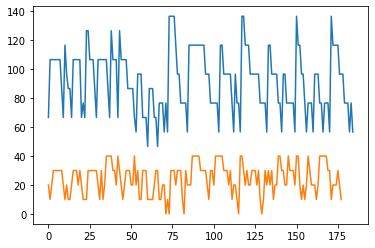

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
#S.DRwaits, S.BUwaits, S.BU_Dem_day, S.DR_Dem_day, S.nBUCustomers , S.nDRCustomers

plt.plot(Results[7], label='BU.Inv')
plt.plot(Results[8], label='DR.Inv')
plt.show()